In [1]:
# Simple implementation of a custom layer
import tensorflow as tf
import numpy as np
from keras import Model, layers, Input
from keras.optimizers import Adam

In [2]:
from keras.datasets import imdb
from keras_preprocessing.sequence import pad_sequences


# load the IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data()

# pad the sequences to the same length
x_train = pad_sequences(x_train, maxlen=200)
x_test = pad_sequences(x_test, maxlen=200)


In [3]:
layers = tf.keras.layers
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0  # check if embed_dim is divisible by num_heads

        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True) # (batch_size, seq_len, seq_len)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) # scalar value of the last dimension of key
        #scale the score to avoid the gradient vanishing problem
        scaled_score = score / tf.math.sqrt(dim_key) # (batch_size, seq_len, seq_len) / scalar
        weights = tf.nn.softmax(scaled_score, axis=-1) # (batch_size, seq_len, seq_len)

        output = tf.matmul(weights, value)
        # (batch_size, seq_len, seq_len) * (batch_size, num_heads, seq_len, embed_dim/num_heads) = (batch_size, num_heads, seq_len, embed_dim/num_heads)

        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.embed_dim // self.num_heads))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(query, batch_size)  # (batch_size, num_heads, seq_len, embed_dim/num_heads)
        key = self.separate_heads(key, batch_size)  # (batch_size, num_heads, seq_len, embed_dim/num_heads)
        value = self.separate_heads(value, batch_size)  # (batch_size, num_heads, seq_len, embed_dim/num_heads)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, embed_dim/num_heads)
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(concat_attention)  # (batch_size, seq_len, embed_dim)
        return output




When creating a custom layer in TensorFlow, there are a few methods that you will need to implement and some that are optional but can provide extra functionality if needed.

Here's a brief overview of them:

init(): This method is called when the layer is created. It's used to initialize the layer and its parameters.
build(input_shape): This method is used to create the layer's weights. The input_shape parameter is a tuple that contains the shape of the input data the layer will process. This method is the place where you can add weights that depend on the input shape.
**call(inputs, kwargs): This is where the layer's logic lives. This method processes the inputs and applies operations using the weights initialized in the build method.
The above methods are pretty much required for every custom layer. However, there are some optional methods that you might find useful:

get_config(): This method is used to save the configuration of a layer. It returns a Python dictionary containing the configuration of the layer. The dictionary includes the layer's name, its parameters, and its weights.
from_config(config): This method takes the output of get_config() to create a new layer instance that's identical to the one the configuration was saved from.
compute_output_shape(input_shape): This method is used to compute the output shape of the layer given the input shape. It is useful when you want to stack multiple layers together and need to check if the output shape of one layer matches the input shape of the next layer.
compute_mask(inputs, mask=None): This is used when your layer modifies the mask or creates a new one. By default, this is just pass through for any masks.
Remember that the most important methods are build() and call(). Most of the time, you'll just need to implement these two methods to create a custom layer in TensorFlow
.



In [4]:

# Hyperparameters
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
# Find the maximum word index in x_train and x_test
max_word_index = max(np.max(x_train), np.max(x_test))
# Set vocab_size to be at least as large as max_word_index + 1
vocab_size = max_word_index + 1  # Add 1 because word indices start from 1
max_sequence_length = x_train.shape[1]  # The length of each sequence

# Define the model
inputs = Input(shape=(max_sequence_length,))
embedding_layer = layers.Embedding(vocab_size, embed_dim)(inputs)
attention_layer = MultiHeadSelfAttention(embed_dim, num_heads)(embedding_layer)
pooling_layer = layers.GlobalAveragePooling1D()(attention_layer)
outputs = layers.Dense(1, activation='sigmoid')(pooling_layer)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_test, y_test))


Epoch 1/2


2023-06-24 11:53:38.717409: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


782/782 [==============================] - 22s 28ms/step - loss: 0.3605 - accuracy: 0.8400 - val_loss: 0.2867 - val_accuracy: 0.8828
Epoch 2/2
782/782 [==============================] - 22s 28ms/step - loss: 0.1631 - accuracy: 0.9394 - val_loss: 0.3470 - val_accuracy: 0.8619


In [5]:
# loss of 0.0788
# Evaluating the model
model.evaluate(x_test, y_test)

# 782/782 [==============================] - 6s 7ms/step - loss: 0.3520 - accuracy: 0.8654

782/782 [==============================] - 6s 7ms/step - loss: 0.3470 - accuracy: 0.8619


[0.347002238035202, 0.8619199991226196]

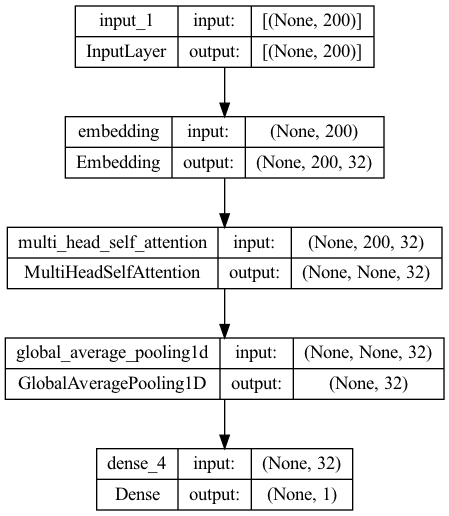

In [6]:
# plot model
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
# do single prediction
# predict probabilities for test set first exemple
yhat_probs = model.predict(x_test, verbose=0)
print(yhat_probs[0])

[0.0749354]
